In [38]:
#%pip install --upgrade hyperspectral_gta_data

In [14]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import copy
import spectral
import pyqtgraph as pg

# module that is useful for reloading packages
import importlib

# Scripts associated with the SML4SI textbook
import hyperspectral_gta_data as hsi_data
import scripts_M2 as sm2

## In this notebook we will introduce **anomaly detection**.

We will be using a common anomaly detection algorithm called RX, named for its inventors:
Reed I., and X. Yu, "Adaptive Multiple-Band CFAR Detection of an Optical Pattern with Unknown Spectral Distribution." IEEE Transactions on Acoustics, Speech and Signal Processing 38 (1990): 1760-1770.

This is a good anomaly detection method for many domains.  For further information see the reference "Hyperspectral Anomaly Detection Based on Machine Learning: An Overview" provided in the references folder with this notebook.

## Algorithm:

We model the image as a multivariate normal distribution.  That is, each pixel spectrum $x$ is from a multivariate normal distribution:
$$
    x \sim \mathcal{N}(\mu,\,\Sigma).
$$

We estimate the mean $\mu$ and covaraince $\Sigma$ from the full image.  Then the RX anomaly score for each pixel $x$ is the Mahalanobis distance
$$
    RX(x) = \sqrt{(x-\mu)^T {\Sigma}^{-1} (x-\mu)}
$$

The original RX paper observed that that theoretically, $RX(x)$ has chi-squared distribution that can support estimating a constant false alarm rate (CFAR) threshld. However, the data often does not match the theory sufficiently, and a heuristic threshold is needed.

The steps are:
1. Load a hyperspectral image.
2. Compute the mean $\mu$ and covariance $\Sigma$.
3. Compute the Mahalanobis Distance for each pixel.

# 1. Load Data

In [20]:
# Here are the datasets available through the hyperspectral_gta_data package
hsi_data.available_datasets()

Available Images:
   WashingtonDC
   MicroscenePolymers
   Detection_Imagery_Cooke_City_RIT
   VegBaccharisUPWINS
   PaintDetectionUPWINS
   indian_pines
   pavia_centre
   pavia_university
Available Spectral Libraries:
   GHISACONUS_2008_001_speclib
   Microscene_Polymers_Library
   UPWINS_4_16_2024
   Detection_Library_Cooke_City_RIT


In [9]:
%pip install rasterio

  Using cached rasterio-1.4.2-cp311-cp311-win_amd64.whl.metadata (9.4 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached attrs-24.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl.metadata (6.4 kB)
Using cached rasterio-1.4.2-cp311-cp311-win_amd64.whl (25.4 MB)
Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
Using cached affine-2.4.0-py3-none-any.whl (15 kB)
Using cached attrs-24.2.0-py3-none-any.whl (63 kB)
Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
# To download and use the polymers image:
hsi_data.download('Detection_Imagery_Cooke_City_RIT')
fname = hsi_data.get_fname('Detection_Imagery_Cooke_City_RIT')

Available Files:
C:\spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT\blind_test_refl
C:\spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT\blind_test_refl.hdr
C:\spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT\blind_test_refl.img
C:\spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT\IGARSS_2008_Snyder.pdf
C:\spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT\self_test_refl
C:\spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT\self_test_refl.hdr
C:\spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT\self_test_refl.img
C:\spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT\self_test_refl_gt.txt
Primary Image Filename:
C:/spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT/self_test_refl


In [39]:
# load the Cooke City hyperspectral iamge
fname = 'C:\spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT/self_test_refl'
fname_hdr = 'C:\spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT/self_test_refl.hdr'

# Open the image and read into an array
im = spectral.envi.open(fname_hdr, fname)
wl = np.asarray(im.bands.centers)
# Load the image into memory
im.Arr = im.load()
imArr = im.Arr
print(f'Shape of ImArr = {imArr.shape}')
imList = np.reshape(imArr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of imList = {imList.shape}')

Shape of ImArr = (280, 800, 126)
Shape of imList = (224000, 126)


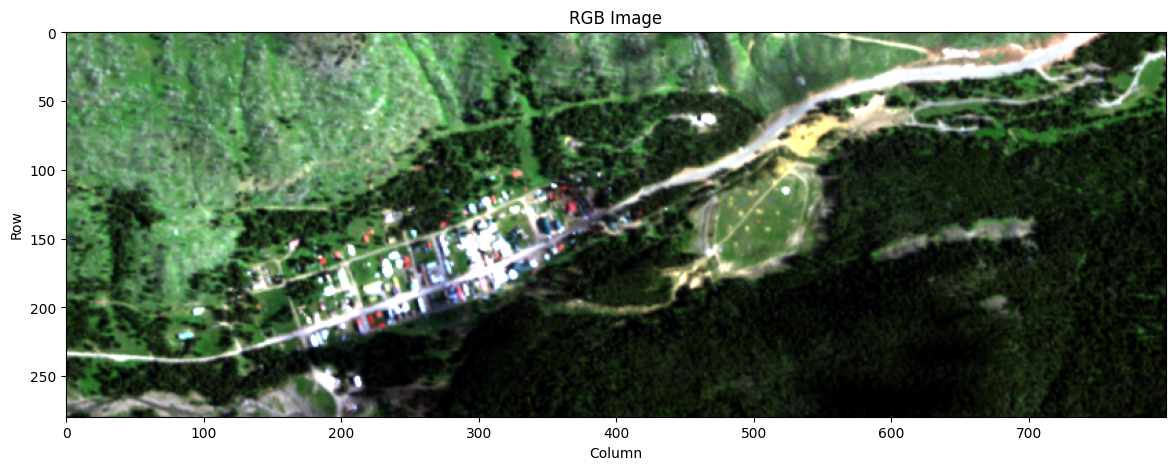

In [23]:
sm2.display_RGB(imArr, wl, rotate=False)
plt.title('RGB Image');

In [41]:
# explore the image in our hyperspectral image viewer
from hsiViewer import hsi_viewer as hv
hv.viewer(im)

x,y = [166,252]
x,y = [169,252]
x,y = [174,253]
x,y = [138,293]
x,y = [128,313]
x,y = [131,337]


# 2. Compute the mean and covariance from the image.

In [42]:
C = np.cov(imList.T) 
m = np.mean(imList, axis=0)

# 3. Compute the Mahalanobis Distance for each pixel

## Whiten the Image

In [43]:
# Compute the eigenvectors, eigenvalues, and whitening matrix
evals,evecs = np.linalg.eig(C)
# truncate the small eigenvalues to stablize the inverse
#evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
W = np.matmul(evecs,DiagMatrix)
ImListDemean = imList - m
WimList = np.matmul(W.T, ImListDemean.T).T

RXlist = np.sqrt(np.sum(WimList**2, axis=1))
RX = np.reshape(RXlist, (im.nrows,im.ncols))

In [44]:
np.max(RX)

np.float64(142.21498379407916)

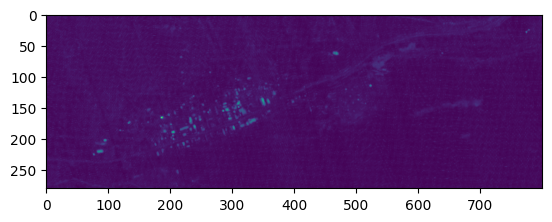

In [28]:
plt.imshow(RX)

In [45]:
# explore the image in our hyperspectral image viewer
from hsiViewer import hsi_viewer_layers as hvl
layers = {
    'RX': RX
}
hvl.viewer(im, layers=layers)

x,y = [62,467]
x,y = [137,348]
x,y = [138,350]
x,y = [137,348]
x,y = [139,350]
x,y = [137,349]
x,y = [156,360]
x,y = [156,358]
x,y = [125,368]
x,y = [127,368]
x,y = [137,503]
x,y = [131,491]
x,y = [142,495]
x,y = [156,496]
x,y = [154,487]
x,y = [143,515]
x,y = [144,502]
x,y = [145,502]
x,y = [145,501]
x,y = [145,502]
x,y = [145,502]
x,y = [147,501]
x,y = [147,503]
x,y = [144,502]
x,y = [144,503]


# Visualizing the data and parameters

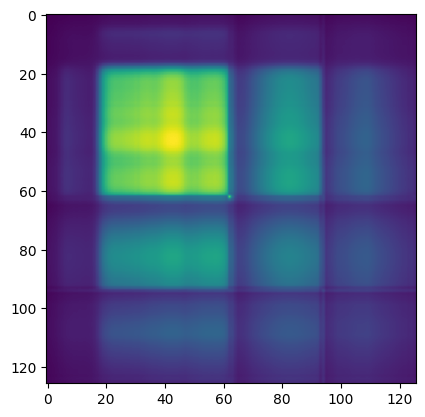

In [30]:
plt.imshow(C);

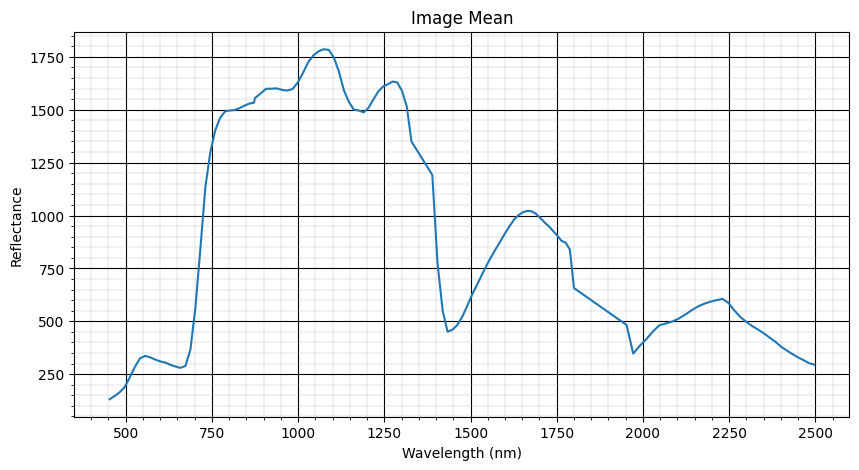

In [31]:
plt.figure(figsize=(10,5))
plt.plot(wl, m)
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.title('Image Mean')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance');

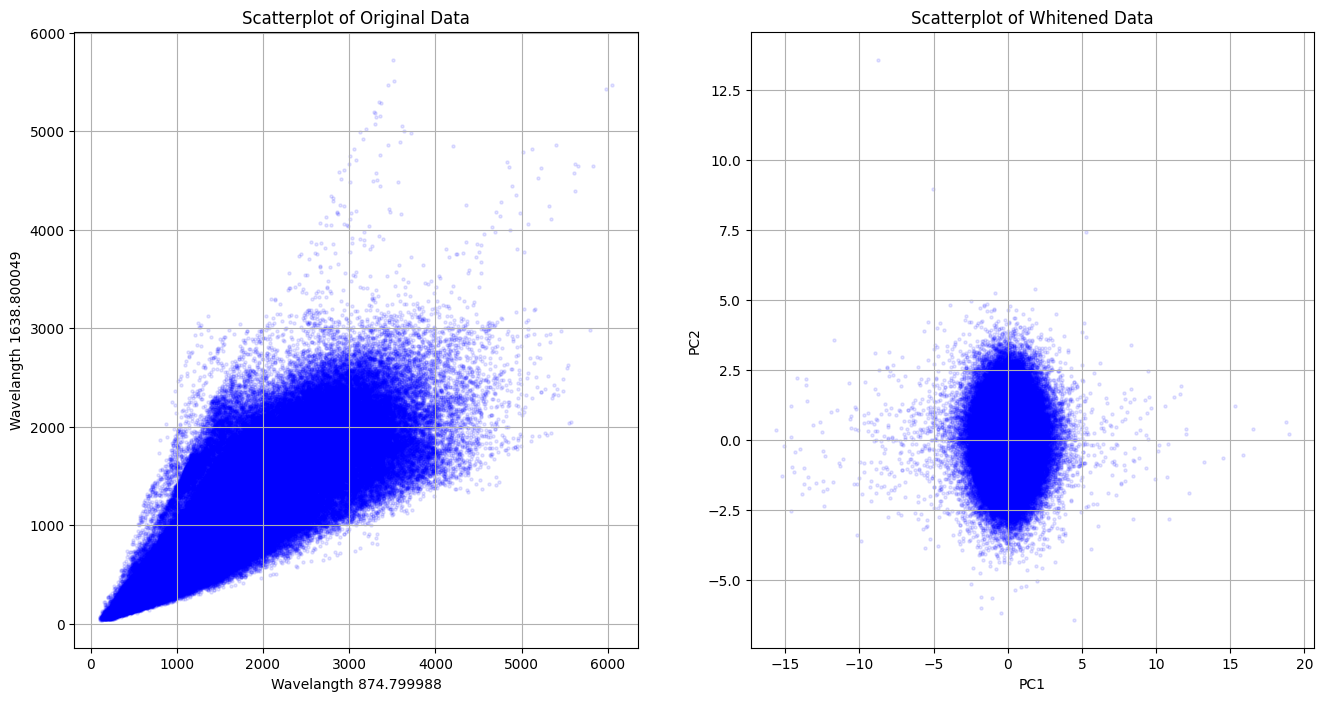

In [32]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)  
plt.title('Scatterplot of Original Data')
plt.scatter(imList[:,30],imList[:,80], s=5, c='b', alpha=0.1)
plt.xlabel(f'Wavelangth {wl[30]}')
plt.ylabel(f'Wavelangth {wl[80]}')
plt.grid(True)

plt.subplot(1, 2, 2)  
plt.title('Scatterplot of Whitened Data')
plt.scatter(WimList[:,30],WimList[:,80], s=5, c='b', alpha=0.1)
plt.xlabel(f'PC1')
plt.ylabel(f'PC2');
plt.grid(True)

In [46]:
# creating a plot window
plot = pg.plot() 
# creating a scatter plot item
# of size = 10
# using brush to enlarge the of green color
scatter = pg.ScatterPlotItem(
    size=10, brush=pg.mkBrush(30, 255, 35, 255)) 
# data for x-axis
x_data = imList[:,30].flatten()
# data for y-axis
y_data = imList[:,80].flatten()
# adding spots to the scatter plot
scatter.addPoints(x_data, y_data) 
# add item to plot window
# adding scatter plot item to the plot window
plot.addItem(scatter)
pg.exec()

0

In [47]:
# creating a plot window
plot = pg.plot() 
# creating a scatter plot item
# of size = 10
# using brush to enlarge the of green color
scatter = pg.ScatterPlotItem(
    size=10, brush=pg.mkBrush(30, 255, 35, 255)) 
# data for x-axis
x_data = WimList[:,30].flatten()
# data for y-axis
y_data = WimList[:,80].flatten()
# adding spots to the scatter plot
scatter.addPoints(x_data, y_data) 
# add item to plot window
# adding scatter plot item to the plot window
plot.addItem(scatter)
pg.exec()

0

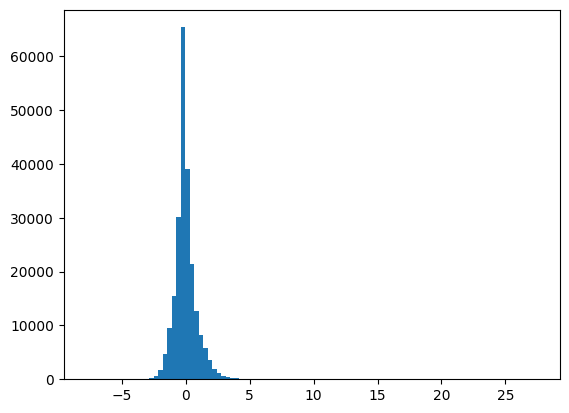

In [ ]:
plt.hist(WimList[:,3].flatten(), bins=100);

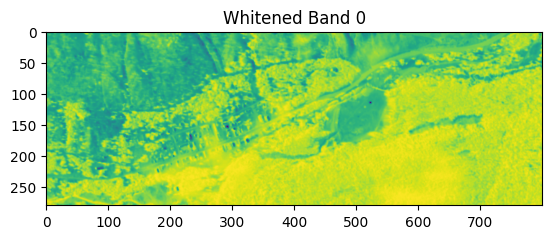

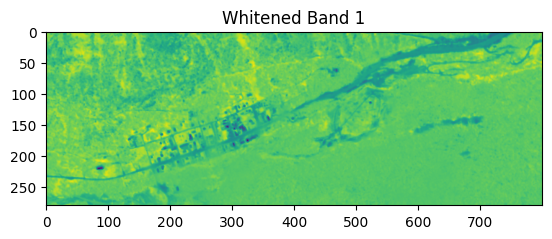

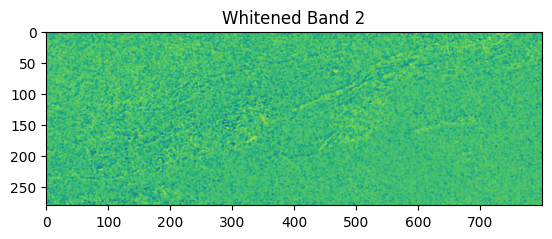

In [ ]:
for i in range(3):
    plt.figure()
    plt.imshow(np.reshape(WimList[:,i], (im.nrows,im.ncols)))
    plt.title(f'Whitened Band {i}')

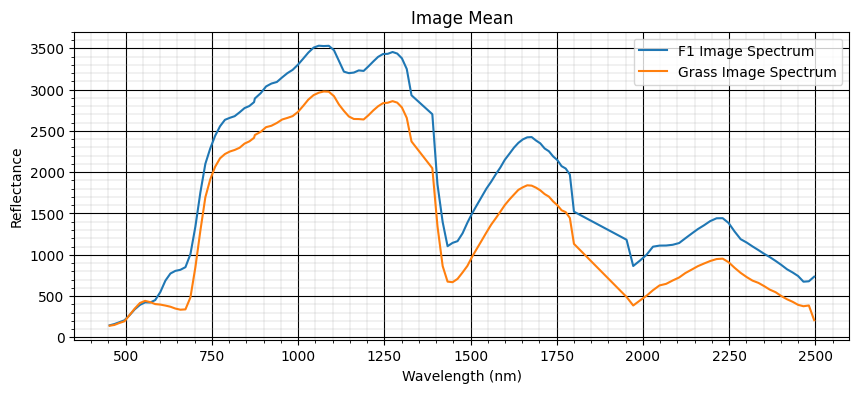

In [ ]:
F1_idx = [137,503]
imSpec_F1 = imArr[F1_idx[0], F1_idx[1], :].flatten()
Grass_idx = [139,507]
imSpec_Gr = imArr[Grass_idx[0], Grass_idx[1], :].flatten()

plt.figure(figsize=(10,4))
plt.plot(wl, imSpec_F1, label='F1 Image Spectrum')
plt.plot(wl, imSpec_Gr, label='Grass Image Spectrum')
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.title('Image Mean')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend();



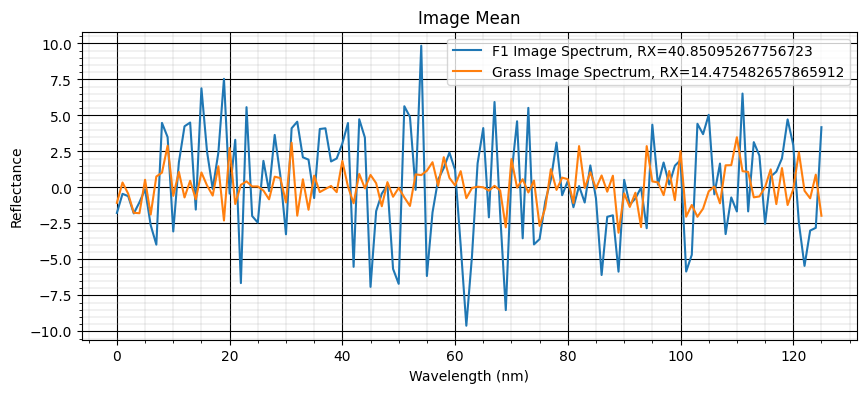

In [13]:
WimArr = np.reshape(WimList, (im.nrows,im.ncols,im.nbands))
F1_idx = [137,503]
WimSpec_F1 = WimArr[F1_idx[0], F1_idx[1], :].flatten()
Grass_idx = [139,507]
WimSpec_Gr = WimArr[Grass_idx[0], Grass_idx[1], :].flatten()


plt.figure(figsize=(10,4))
plt.plot(WimSpec_F1, label=f'F1 Image Spectrum, RX={RX[F1_idx[0], F1_idx[1]]}')
plt.plot(WimSpec_Gr, label=f'Grass Image Spectrum, RX={RX[Grass_idx[0], Grass_idx[1]]}')
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.title('Image Mean')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend();

NameError: name 'imSpec_Gr' is not defined

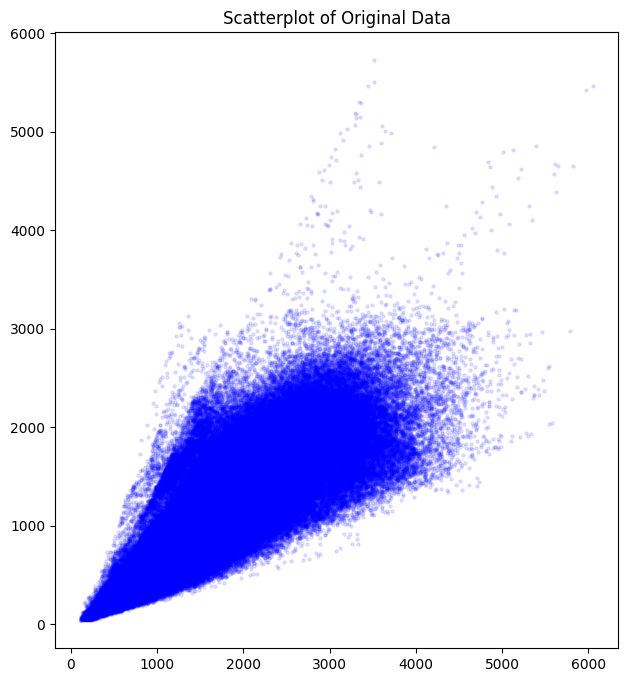

In [14]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)  
plt.title('Scatterplot of Original Data')
plt.scatter(imList[:,30],imList[:,80], s=5, c='b', alpha=0.1)
plt.scatter(imSpec_Gr[30], imSpec_Gr[80], c='g', s=20)
plt.scatter(imSpec_F1[30], imSpec_F1[80], c='r', s=20)
plt.xlabel(f'Wavelangth {wl[30]}')
plt.ylabel(f'Wavelangth {wl[80]}')
plt.grid(True)

PC1 = 30
PC2 = 61
plt.subplot(1, 2, 2)  
plt.title('Scatterplot of Whitened Data')
plt.scatter(WimList[:,PC1],WimList[:,PC2], s=5, c='b', alpha=0.1)
plt.scatter(WimSpec_Gr[PC1], WimSpec_Gr[PC2], c='g', s=20)
plt.scatter(WimSpec_F1[PC1], WimSpec_F1[PC2], c='r', s=20)
plt.xlabel(f'PC1')
plt.ylabel(f'PC2');
plt.grid(True)